## Section 0. Import Packages

In [1]:
# Import Basic Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import random
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 200)

# Import Regression Packages
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,RandomForestRegressor,ExtraTreesRegressor,BaggingRegressor
from sklearn.linear_model import LinearRegression,HuberRegressor,ElasticNet,LassoCV,RidgeCV,PassiveAggressiveRegressor,SGDRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.grid_search import GridSearchCV

## Section 1. Data Pre-Processing

### Section 1.1 Reading Dataframe

In [2]:
# Read-in the full data set
data = pd.read_csv('Final_Dataframe.csv')

In [3]:
# Drop name column
data = data.drop("Unnamed: 0", axis=1)

In [4]:
word_lis = []
for word in data.columns:
    word = word.lstrip(' ').strip('\'')
    word_lis.append(word)
    
data.columns = word_lis

In [5]:
# Remove duplicate columns by name
def remove_dup_columns(frame):
    keep_names = set()
    keep_icols = list()
    for icol, name in enumerate(frame.columns):
        if name not in keep_names:
            keep_names.add(name)
            keep_icols.append(icol)
    return frame.iloc[:, keep_icols]

data_sub = remove_dup_columns(data)

In [6]:
data_sub.describe()

,acousticness_mean,acousticness_std,dance_mean,dance_std,energy_mean,energy_std,instrumentalness_mean,instrumentalness_std,key_mean,key_std,liveness_mean,liveness_std,loudness_mean,loudness_std,mode_mean,mode_std,speech_mean,speech_std,tempo_mean,tempo_std,time_mean,time_std,valence_mean,valence_std,Followers,followers_mean,followers_std,popularity_mean,popularity_std,top_0_10,top_10_20,top_20_30,top_30_40,top_40_50,acid house,album rock,alternative country,alternative dance,alternative metal,alternative pop,alternative rock,alternative roots rock,ambient,anthem emo,anthem worship,anti-folk,art rock,athens indie,austindie,australian alternative rock,australian dance,australian hip hop,australian pop,avant-garde,azonto,azontobeats,bass music,bay area indie,bebop,big band,big beat,big room,bluegrass,blues,blues-rock,boogie-woogie,bossa nova,boston rock,bow pop,breakbeat,brill building pop,british alternative rock,british blues,british folk,british indie rock,british invasion,britpop,brooklyn indie,brostep,bubblegum pop,c86,cabaret,canadian indie,canadian metal,canadian pop,candy pop,canterbury scene,catstep,ccm,cello,celtic rock,chamber pop,chamber psych,chaotic hardcore,chicago blues,chicago house,chicago indie,chicago soul,chillhop,chillstep,...,channel pop,christian dance,college a cappella,colombian rock,columbus ohio indie,comedy,cubaton,cumbia pop,dancehall,danish indie,deep contemporary country,deep disco house,deep east coast hip hop,deep euro house,deep funk carioca,deep german pop rock,deep soundtrack,deep swedish indie pop,desert blues,dutch rock,electro latino,electropowerpop,gabba,halloween,j-ambient,j-poppunk,j-punk,japanese city pop,jazz metal,lowercase,meditation,michigan indie,neo-rockabilly,neo-synthpop,new age,northern irish indie,norwegian indie,nu age,polka,progressive deathcore,psychedelic doom,quebecois,relaxative,spanish pop,speed garage,vancouver indie,vegas indie,viral pop,no_genre,Lil Wayne,Van Morrison,Galantis,Wiz Khalifa,Rihanna,Post Malone,Axwell /\ Ingrosso,Young Thug,JAY Z,A$AP Rocky,Yo Gotti,Chance The Rapper,Led Zeppelin,Otis Redding,21 Savage,Deorro,Elton John,SZA,Ty Dolla $ign,Ryan Adams,Birdy,Miguel,Niall Horan,Ellie Goulding,Commodores,Radiohead,SYML,First Aid Kit,Lord Huron,Str_Best,Str_Workout,Str_Party,Str_Chill,Str_Acoustic,Str_2000s,Str_1990s,Str_1980s,Str_1970s,Str_1960s,house_acousticness_mean,hip hop_acousticness_std,pop_liveness_std,dance_liveness_std,r&b_acousticness_std,rap_energy_std,rap_key_std,acoustic_acousticness_std,acoustic_acousticness_mean,acoustic_energy_std,acoustic_key_std,soul_acousticness_std
count,1420.000000,1418.000000,1420.000000,1418.000000,1420.000000,1418.000000,1420.000000,1418.000000,1420.000000,1418.000000,1420.000000,1418.000000,1420.000000,1418.000000,1420.000000,1.418000e+03,1420.000000,1418.000000,1420.000000,1418.000000,1420.000000,1.418000e+03,1420.000000,1418.000000,1.420000e+03,1420.000000,1.369000e+03,1420.000000,1369.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,...,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.0

In [7]:
data_master = pd.read_csv('../spotify_data_master.csv').drop("Unnamed: 0", axis=1)
data_master.describe()

,acousticness_mean,acousticness_std,dance_mean,dance_std,energy_mean,energy_std,instrumentalness_mean,instrumentalness_std,key_mean,key_std,liveness_mean,liveness_std,loudness_mean,loudness_std,mode_mean,mode_std,speech_mean,speech_std,tempo_mean,tempo_std,time_mean,time_std,valence_mean,valence_std,Followers,followers_mean,followers_std,popularity_mean,popularity_std,top_0_10,top_10_20,top_20_30,top_30_40,top_40_50,Playlist_Followers,"""children's christmas""","""children's christmas"".1","""children's music""","""children's music"".1",'acid house','acid techno','adult standards','afrobeat','afrobeats','album rock','alternative country','alternative country'.1,'alternative dance','alternative hip hop','alternative hip hop'.1,'alternative metal','alternative pop','alternative rock','alternative roots rock','ambeat','ambient idm','ambient','anime score','anthem emo','anthem emo'.1,'anthem worship','anti-folk','antiviral pop','appalachian folk','art rock','athens indie','atmospheric post-metal','aussietronica','austindie','australian alternative rock','australian dance','australian dance'.1,'australian hip hop','australian indie','australian pop','australian pop'.1,'avant-garde jazz','avant-garde','avantgarde metal','azonto','azonto'.1,'azontobeats','azontobeats'.1,'balearic','ballroom','baroque ensemble','bass music','bass trap','bassline','bay area indie','bay area indie'.1,'bebop','belly dance','big band','big beat','big room','big room'.1,'black death','black metal','black sludge',...,'swing','swiss rock','symphonic black metal','synthpop','talent show','tango','tango'.1,'tech house','technical brutal death metal','technical brutal death metal'.1,'technical death metal','teen pop','teen pop'.1,'texas blues','texas country','theme','thrash-groove metal','throat singing','tin pan alley','tin pan alley'.1,'tone','tracestep','tracestep'.1,'traditional british folk','traditional country','traditional folk','traditional funk','traditional rockabilly','traditional scottish folk','traditional soul','traditional swing','trap francais','trap latino','trap music','trash rock','triangle indie','tribal house','tribal house'.1,'tribute','trip hop','tropical house','trova','turbo folk','turkish folk','turkish jazz','turkish jazz'.1,'turntablism','twee pop','tzadik','uk drill','uk hip hop','ukulele','unblack metal','underground hip hop','underground latin hip hop','underground pop rap','underground power pop','underground rap','vancouver indie','vapor house','vapor pop','vapor pop'.1,'vapor soul','vapor soul'.1,'vapor twitch','vaporwave','vegas indie','video game music','vintage jazz','vintage reggae','vintage swedish pop','vintage swing','vintage western','vintage western'.1,'violin','viral pop','vocal house','vocal jazz','vocaloid','voidgaze','warm drone','welsh rock','west coast trap','wind ensemble','wonky','world chill','world christmas','world fusion','world meditation','world','wrestling','wrock','ye ye','yoik','zapstep','zeuhl','zim','zolo','zydeco','no_genre'
count,1420.000000,1418.000000,1420.000000,1418.000000,1420.000000,1418.000000,1420.000000,1418.000000,1420.000000,1418.000000,1420.000000,1418.000000,1420.000000,1418.000000,1420.000000,1418.000000,1420.000000,1418.000000,1420.000000,1418.000000,1420.000000,1418.000000,1420.000000,1418.000000,1.420000e+03,1.420000e+03,1.369000e+03,1420.000000,1369.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1.420000e+03,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.0000

In [8]:
# ID and Password for accessing Spotify API
client_id = "14aed07d00e342a6a989d64d6c7f3d02"
client_secret = "19f0f88834b6425aa9b8bc129279426f"
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

### Section 1.3 Standardization

In [9]:
# List all numerical columns to be used for classification
numerical_columns = ['acousticness_mean','acousticness_std','dance_mean','dance_std',\
                    'energy_mean','energy_std','instrumentalness_mean','instrumentalness_std',\
                    'key_mean','key_std','liveness_mean','liveness_std','loudness_mean',\
                    'loudness_std','mode_mean','mode_std','speech_mean','speech_std',\
                    'tempo_mean','tempo_std','valence_mean','valence_std','followers_mean',\
                    'followers_std','popularity_mean','popularity_std',\
                    'house_acousticness_mean', 'hip hop_acousticness_std','pop_liveness_std', \
                     'dance_liveness_std', 'r&b_acousticness_std','rap_energy_std', 'rap_key_std',\
                     'acoustic_acousticness_std','acoustic_acousticness_mean', 'acoustic_energy_std',\
                     'acoustic_key_std']

In [10]:
# The numerical columns are standardized next
mean = data_sub[numerical_columns].mean()
std = data_sub[numerical_columns].std()

data_sub[numerical_columns] = (data_sub[numerical_columns] - mean)/std

### Section 1.4 Imputation

In [11]:
# Find Missing Columns
null_vals = data_sub.isnull().sum()
missing_vals = null_vals[null_vals > 0].index.tolist()

#### Median-Based Imputation

In [12]:
# Median imputation of missing values
imp = Imputer(missing_values='NaN', strategy='median', axis=1)
data_sub = pd.DataFrame(imp.fit_transform(data_sub), columns=data_sub.columns)

In [13]:
# Split training and test data
data_sub = data_sub[data_sub['Followers'] != 0]

In [14]:
# Final step: create y_train/x_train and y_test/x_test dataframes

# Initialize the training data
y_train = np.log(data_sub['Followers'])
x_train = data_sub.drop('Followers', axis=1)

In [15]:
x_train.describe()

,acousticness_mean,acousticness_std,dance_mean,dance_std,energy_mean,energy_std,instrumentalness_mean,instrumentalness_std,key_mean,key_std,liveness_mean,liveness_std,loudness_mean,loudness_std,mode_mean,mode_std,speech_mean,speech_std,tempo_mean,tempo_std,time_mean,time_std,valence_mean,valence_std,followers_mean,followers_std,popularity_mean,popularity_std,top_0_10,top_10_20,top_20_30,top_30_40,top_40_50,acid house,album rock,alternative country,alternative dance,alternative metal,alternative pop,alternative rock,alternative roots rock,ambient,anthem emo,anthem worship,anti-folk,art rock,athens indie,austindie,australian alternative rock,australian dance,australian hip hop,australian pop,avant-garde,azonto,azontobeats,bass music,bay area indie,bebop,big band,big beat,big room,bluegrass,blues,blues-rock,boogie-woogie,bossa nova,boston rock,bow pop,breakbeat,brill building pop,british alternative rock,british blues,british folk,british indie rock,british invasion,britpop,brooklyn indie,brostep,bubblegum pop,c86,cabaret,canadian indie,canadian metal,canadian pop,candy pop,canterbury scene,catstep,ccm,cello,celtic rock,chamber pop,chamber psych,chaotic hardcore,chicago blues,chicago house,chicago indie,chicago soul,chillhop,chillstep,chillwave,...,channel pop,christian dance,college a cappella,colombian rock,columbus ohio indie,comedy,cubaton,cumbia pop,dancehall,danish indie,deep contemporary country,deep disco house,deep east coast hip hop,deep euro house,deep funk carioca,deep german pop rock,deep soundtrack,deep swedish indie pop,desert blues,dutch rock,electro latino,electropowerpop,gabba,halloween,j-ambient,j-poppunk,j-punk,japanese city pop,jazz metal,lowercase,meditation,michigan indie,neo-rockabilly,neo-synthpop,new age,northern irish indie,norwegian indie,nu age,polka,progressive deathcore,psychedelic doom,quebecois,relaxative,spanish pop,speed garage,vancouver indie,vegas indie,viral pop,no_genre,Lil Wayne,Van Morrison,Galantis,Wiz Khalifa,Rihanna,Post Malone,Axwell /\ Ingrosso,Young Thug,JAY Z,A$AP Rocky,Yo Gotti,Chance The Rapper,Led Zeppelin,Otis Redding,21 Savage,Deorro,Elton John,SZA,Ty Dolla $ign,Ryan Adams,Birdy,Miguel,Niall Horan,Ellie Goulding,Commodores,Radiohead,SYML,First Aid Kit,Lord Huron,Str_Best,Str_Workout,Str_Party,Str_Chill,Str_Acoustic,Str_2000s,Str_1990s,Str_1980s,Str_1970s,Str_1960s,house_acousticness_mean,hip hop_acousticness_std,pop_liveness_std,dance_liveness_std,r&b_acousticness_std,rap_energy_std,rap_key_std,acoustic_acousticness_std,acoustic_acousticness_mean,acoustic_energy_std,acoustic_key_std,soul_acousticness_std
count,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1.396000e+03,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.00000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,...,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.00000

In [16]:
# GradientBoostingRegressor
model = GradientBoostingRegressor(alpha=0.99, 
                                  loss='huber', 
                                  max_depth=5, 
                                  learning_rate=0.04, 
                                  n_estimators=200, 
                                  max_features='auto')
model.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.99, criterion='friedman_mse', init=None,
             learning_rate=0.04, loss='huber', max_depth=5,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [17]:
green_col = np.divide([30, 215, 96],255)
black_col = [0,0,0]
gray_col = np.divide([150,150,150],255)
light_gray_col = np.divide([236, 235, 232],255)
white_col =  np.divide([255, 255, 255],255)
med_gray_col = np.divide([80,80,80], 255)

colors = [green_col, black_col, gray_col, light_gray_col, white_col]

afont = {'fontname':'AppleGothic'}
hfont = {'fontname':'Helvetica'}
ifont = {'fontname': 'Impact'}
arfont = {'fontname': 'Arial'}
ofont = {'fontname': 'Osaka'}
sfont = {'fontname': 'STHeiti'}
hirafont = {'fontname': 'Hiragino Kaku Gothic ProN'}

## Generating Successful Playlists

### Methodology

One of the high-level project goals was to

> "use a regression based model to generate new playlists according to a user-specified genre or other search filter."

To this extent, the fitted Gradient Boosting Regressor has been used. Specifically, the process of generating a playlist based on user-specified genre or other criteria is:

1. Select a subframe of the data (from the master dataframe) based on the user-specified preference (e.g., genre, audio feature or artist)
2. Employ the fitted Gradient Boosting Regressor model to predict which playlist from the sub-dataframe would most likely have the most followers (using all predictors available)
3. From the predicted most popular playlist, sample a number of songs randomly (where the user can specify how many songs are desired)
4. Return the song selection and provide the possibility to plot additional metrics

In [18]:
def optimized_playlist(style, song_count, summary=True, plot=False):
    '''Returns playlist songs most-likely to be popular given a style'''
    
    play_index = np.argmax(model.predict(x_train[x_train[style] == 1.0]))
    data_index = x_train[x_train[style] == 1.0].index[play_index]
    playlist_id = data_master.loc[data_index]["ID"]
    
    results = sp.user_playlist_tracks('spotify', playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    
    songs_playlist = []
    for item,song in enumerate(tracks):
        song_name = tracks[item]['track']['name']
        songs_playlist.append(song_name)
    
    sample = random.sample(songs_playlist,song_count)
    
    if plot:
        f,ax = plt.subplots(1,1,figsize=(20, 5))
        bin_count = x_train[x_train[style] == 1.0].shape[0]
        ax.hist(model.predict(x_train[x_train[style] == 1.0]),bins=bin_count,label="Matching Playlists",color=green_col)
        ax.axvline(model.predict(x_train.loc[data_index]),color=black_col,label="Chosen Playlist")
        ax.set_title("Logged Playlist Followers For Playlists That Match Style")
        ax.set_xlabel("Logged Playlist Followers")
        ax.set_ylabel("Frequency")
        ax.set_facecolor(light_gray_col)
        plt.legend()
        plt.show()
    
    if summary:
        return sample

### Examples

For example, if you feel like listening to deep house, simply type "deep house" and the number of songs for your custom playlist. The function will return that number of songs from the most highly rated (in terms of followers) predicted playlist in Spotify.

In [19]:
optimized_playlist("deep house",10)

['Feel Good',
 'Static',
 'Coming Home',
 'Love & War (feat. Yade Lauren)',
 'Living',
 'Only One - Radio Edit',
 'Open',
 'Another Shot',
 'If I Lose Myself - Alesso vs OneRepublic',
 'Let Me Love You']

Similarly, to get a better understanding of all the "deep house" playlists in the data set, simply expand the function request as per the below. The output is a graph which shows the predicted logged followers of all playlists that match the genre "deep house". As is clear, the function samples songs from the most highly rated predicted playlist.

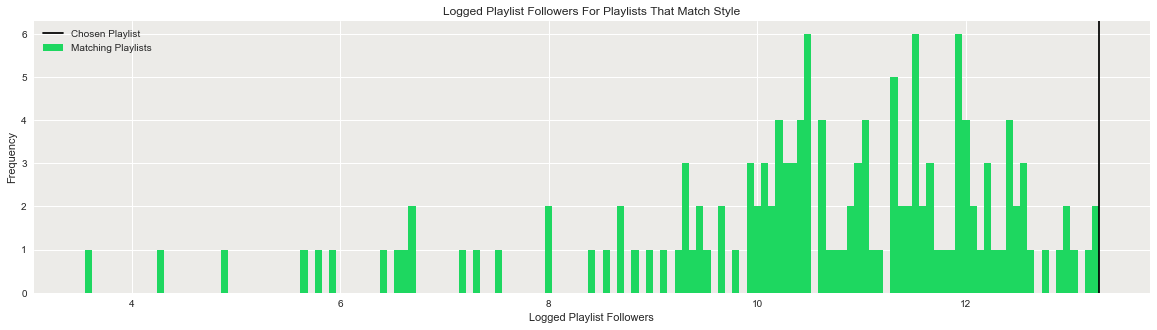

In [20]:
optimized_playlist("deep house",10,summary=False,plot=True)

Other inputs work just as well - for example, assume you are in the mood for "2000s" songs. Simply request "Str_2000s" from the function and the number of songs requested and the output will be a sample of songs from the predicted most highly followed playlist containing "2000s" songs.

In [29]:
optimized_playlist("Str_2000s",5)

['Dani California',
 'Mudshovel - Explicit Album Version',
 'Animal I Have Become',
 'Welcome Home',
 'In The End']

As per the above, to get a better understanding of "2000s" playlist popularity (and to understand from which playlist the songs get sampled), simply request for the plot to display.

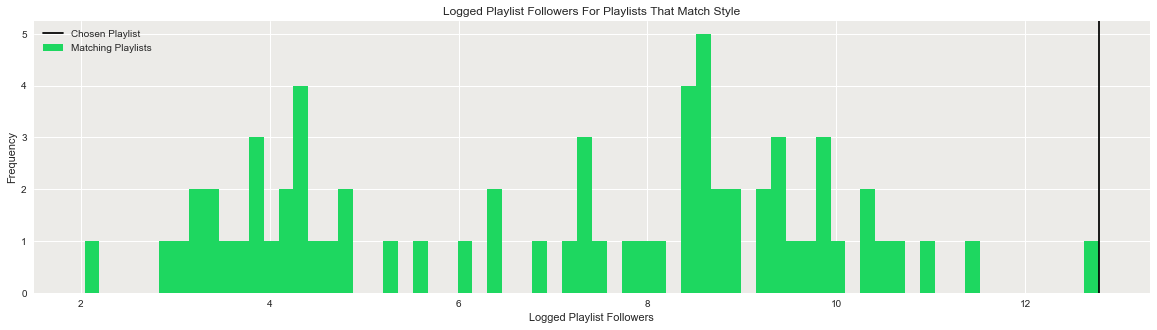

In [30]:
optimized_playlist("Str_2000s",5,summary=False,plot=True)

The example genres showcased above are only a small sample of choices that the playlist generator can deal with - in essence, all predictor columns of the data set could be used (albeit with slightly tweaked inputs) instead as well. Other examples include: "violin", "Str_Workout", "pop", "Rihanna" and hundreds more.

## Conclusion & Future Work

**Conclusion**

Spotify’s music recommendation engine is vital to the company for two primary reasons. First, Spotify's foremost revenue source is its paying customer base - being able to offer these customers good service in the form of relevant music is vital. Second, Spotify is incentivized to provide non-paying customers with relevant recommendations in the hope of converting those customers to paying ones instead. 

With this backdrop in mind, we set out to accomplish two main tasks:

1. Determine what variables and model could be used to predict the success of a Spotify playlist (i.e., its follower count) more accurately than relying on a simple baseline model.

2. Generate custom playlists, according to user-specified filters, which are deemed likely to be popular using the aforementioned fitted model.

A total of 9 baseline models were fitted on our training set and evaluated out-of-sample on the test set. Example models include variations of simple multiple linear regression including regularization and principal component analysis. A further 9 advanced models were trained and tested along similar procedures - advanced models include neural networks, random forests, boosted regression trees and support vector regressors among others. 

Out of the baseline models examined, out-of-sample performance in terms of r-squared was highest for multiple linear regression on a reduced set of dimensions using PCA with $R^2=0.13$ on the log-value of playlist follower count. The best performing model overall was the gradient boosted regressor with $R^2=0.36$ on the log-value of playlist follower count.

The most important features for the gradient boosted regressor were found to be (i) the audio features mean valence and mean danceability and (ii) the mean popularity of the artists in the playlists. Overall, these features are deemed intuitive a playlist's popularity.

Finally, the optimized gradient boosted regressor was also used to generate custom playlists according to user-specified filters. Overall, the songs put forward by the model are deemed a propos given the filters and overall decent suggestions are made.

**Future Work**

Potential additional insights and improved model accuracy could be gained in future work by expanding the feature space to include for example non-linearities and polynomial interaction terms. Also, the playlist generation feature could be further enhanced if songs were sampled from a broader range of playlists (and not just from the predicted most succesful playlist) through the use of advanced stochastic optimization algorithms.